# YOLO v9を試す
今回の課題は物体検出タスクである。  
渋谷交差点を定点カメラから撮影した画像を1分ごとに撮影したものだが、実際に用いる際はリアルタイム性が必要だと判断しYOLO v9をベースとして用いる。

In [1]:
from ultralytics import YOLO

model = YOLO("yolov9c.pt")

### 物体検出後の数え上げ方

In [38]:
from collections import defaultdict
from enum import Enum


class ObjectType(Enum):
    """YOLOv9上で利用する番号の列挙型
    
    ex. `ObjectType.person.value` で　`0` が取得できる
    
    """
    person = 0
    bicycle = 1
    car = 2
    motorcycle = 3
    bus = 5
    truck = 7


# CSVファイルのヘッダーを作成しておく
csv_path = "../doc/predict.csv"
with open(csv_path, "w") as f:
    f.write("file_name,persons,bicycles,cars,motorcycles,buses,trucks\n")

sum_dict: dict[str, dict[int, int]] = {
    ObjectType.person.name: defaultdict(int), 
    ObjectType.bicycle.name: defaultdict(int), 
    ObjectType.car.name: defaultdict(int), 
    ObjectType.motorcycle.name: defaultdict(int), 
    ObjectType.bus.name: defaultdict(int), 
    ObjectType.truck.name: defaultdict(int)
}

# 1時間ごとに集計して合計値を辞書に格納する
for h in range(24):
    for m in range(60):
        
        pic_path = f"../data/20240512/20240512_{str(h).zfill(2)}{str(m).zfill(2)}00.jpg"
        results = model(pic_path)
        
        persons, bicycles, cars, motorcycles, buses, trucks = 0, 0, 0, 0, 0, 0
        for target in results[0].boxes.cls:
            if int(target) == ObjectType.person.value:
                sum_dict[ObjectType.person.name][h] += 1
                persons += 1
            if int(target) == ObjectType.bicycle.value:
                sum_dict[ObjectType.bicycle.name][h] += 1
                bicycles += 1
            if int(target) == ObjectType.car.value:
                sum_dict[ObjectType.car.name][h] += 1
                cars += 1
            if int(target) == ObjectType.motorcycle.value:
                sum_dict[ObjectType.motorcycle.name][h] += 1
                motorcycles += 1
            if int(target) == ObjectType.bus.value:
                sum_dict[ObjectType.bus.name][h] += 1
                buses += 1
            if int(target) == ObjectType.truck.value:
                sum_dict[ObjectType.truck.name][h] += 1
                trucks += 1
        # 当該の時間に検出できなかったものの辞書の値は0として扱う
        if persons == 0:
            sum_dict[ObjectType.person.name][h] = 0
        if bicycles == 0:
            sum_dict[ObjectType.bicycle.name][h] = 0
        if cars == 0:
            sum_dict[ObjectType.car.name][h] = 0
        if motorcycles == 0:
            sum_dict[ObjectType.motorcycle.name][h] = 0
        if buses == 0:
            sum_dict[ObjectType.bus.name][h] = 0
        if trucks == 0:
            sum_dict[ObjectType.truck.name][h] = 0
            
        # 処理したファイルで検出された物体の数をCSVに追記する
        with open(csv_path, "a") as f:
            f.write(f"20240512/20240512_{str(h).zfill(2)}{str(m).zfill(2)}00.jpg,{persons},{bicycles},{cars},{motorcycles},{buses},{trucks}\n")



image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000000.jpg: 384x640 18 persons, 3 cars, 1 tv, 749.1ms
Speed: 1.0ms preprocess, 749.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000100.jpg: 384x640 6 persons, 8 cars, 3 traffic lights, 1 tv, 709.4ms
Speed: 1.0ms preprocess, 709.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000200.jpg: 384x640 8 persons, 10 cars, 1 bus, 1 traffic light, 1 tv, 686.2ms
Speed: 1.0ms preprocess, 686.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000300.jpg: 384x640 10 persons, 8 cars, 2 buss, 1 truck, 3 traffic lights, 1 tv, 683.6ms
Speed: 2.0ms preprocess, 683.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 F:\sr

## 20240512の概要

In [40]:
print(f"時間帯ごとの小計:")
for k, v in sum_dict.items():
    print(f"[{k:10}], {dict(v)}")
    print(f"[{k:10}の合計] {sum(v.values()):4}\t[1時間あたりの平均台数] {sum(v.values()) / len(v):7.2f}")


時間帯ごとの小計:
[person    ], {0: 548, 1: 360, 2: 321, 3: 142, 4: 699, 5: 830, 6: 734, 7: 753, 8: 689, 9: 379, 10: 1, 11: 4, 12: 7, 13: 3, 14: 1, 15: 5, 16: 3, 17: 1, 18: 0, 19: 6, 20: 6, 21: 0, 22: 66, 23: 213}
[person    の合計] 5771	[1時間あたりの平均台数]  240.46
[bicycle   ], {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}
[bicycle   の合計]    0	[1時間あたりの平均台数]    0.00
[car       ], {0: 348, 1: 473, 2: 285, 3: 0, 4: 228, 5: 10, 6: 82, 7: 80, 8: 1, 9: 154, 10: 81, 11: 262, 12: 248, 13: 212, 14: 467, 15: 188, 16: 562, 17: 569, 18: 435, 19: 84, 20: 69, 21: 25, 22: 49, 23: 47}
[car       の合計] 4959	[1時間あたりの平均台数]  206.62
[motorcycle], {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 2, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}
[motorcycleの合計]    2	[1時間あたりの平均台数]    0.08
[bus       ], {0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 1, 7: 3, 8: 0,

(0.0, 23.0)

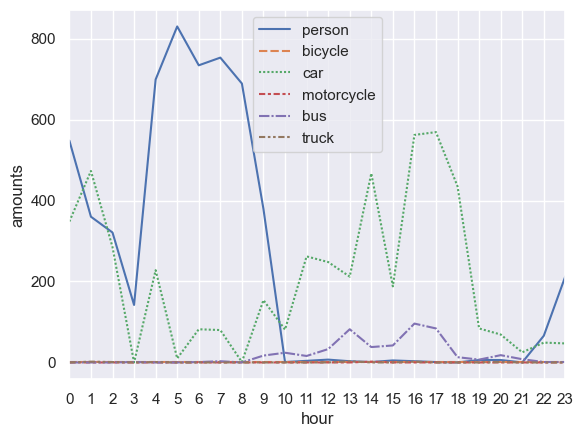

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set()

df = pd.DataFrame({k: v.values() for k, v in sum_dict.items()})
p = sns.lineplot(data=df)

# 日本語の表示ができないため、英語を使う
p.set_xlabel("hour")
p.set_ylabel("amounts")

# 横軸を1時間刻みにして0-23時の間を表示する
p.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
plt.xlim(0, 23)

/data/20240512に存在する画像から物体検出を行った。
/runs に生成された画像を確認すると、正誤はともかく `car`/`truck`/`bus`/`motorcycle` などが検出できている。(ただし、`bus`として検出している中には風景を誤検知しているものも含まれている)  
このままで顧客の要件を満たすかわからないため、目視で確認した範囲で見つけた　`乗用車`/`タクシー`/`バス`/`ゴミ収集車`/`トラック`/`救急車`/`パトカー`/`原付` を分類する方が望ましいか顧客に確認を行う。(依頼: 2024/06/03)

（回答: 20240603　JPT關様）
> ご質問ありがとうございます。  
> ご指摘の通り、モデルの用途で車両の定義は変わります。従い、利用用途の定義も課題のひとつとなります。  
> 自分の興味、社会/業界/企業/個人のニーズ、モデルの性能などを鑑みてご自身で定義してみてください。  
> 定義に正解はなく、説明に一貫性があるか、という点が選考基準となります。  

